In [1]:
import sys
sys.path.append('..') 
import pandas as pd

## Data Loading

In [2]:
# # Save feature_engineered_df 
# feature_engineered_df.to_csv("data/feature_engineered_df.csv")
# # Load feature_engineered_df 
parse_dates = ["date"]
feature_engineered_df = pd.read_csv('data/feature_engineered_df.csv', index_col=[0], parse_dates=parse_dates)
feature_engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4779 entries, 14 to 5912
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         4779 non-null   datetime64[ns]
 1   province                     4779 non-null   object        
 2   current_month_consumption    4779 non-null   float64       
 3   ARIMA_prediction             4779 non-null   float64       
 4   last_year_total_consumption  4779 non-null   float64       
 5   rolling_mean_2               4779 non-null   float64       
 6   rolling_mean_3               4779 non-null   float64       
 7   lag1_monthly_share           4779 non-null   float64       
 8   lag2_monthly_share           4779 non-null   float64       
 9   lag3_monthly_share           4779 non-null   float64       
 10  lag1                         4779 non-null   float64       
 11  lag2                         4779 non-null

## Data Preperation

### Ultimate Train Test Split

In [3]:
from src.model_selection.data_preperation import DataPreperation as dp
model_df = feature_engineered_df.sort_values(by=["date"]).reset_index(drop=True).copy()
main_train, main_test = dp.train_test_split(data=model_df, index_column1="date",index_column2="province",lag=1)

Date range date at train is:  2017-03-01 00:00:00 2021-11-01 00:00:00 with shape of:  (4617, 21)
Date range date at test is:  2021-12-01 00:00:00 2021-12-01 00:00:00 with shape of:  (81, 21)


### Grid Search Train Test Split

In [4]:
# Buraya gerek yok sonra sil
X_train, y_train, X_test, y_test = dp.ts_train_test_split(data=main_train.reset_index(),
                                                          index_column1="date",
                                                          index_column2="province",
                                                          lag=0)

def calc_grid_pairs(dict: dict()):
    prod = 1
    for key, value in dict.items():
        prod *= len(dict[key])
    print("Number of candidates are: ",prod)

Date range date at train is:  2017-03-01 00:00:00 2021-10-01 00:00:00 with shape of:  (4536, 21)
Date range date at test is:  2021-11-01 00:00:00 2021-11-01 00:00:00 with shape of:  (81, 21)
Maximum date at train is:  (Timestamp('2021-10-01 00:00:00'), 'ŞIRNAK')  Shape is:  (4536, 19)
Minimum date at train is:  (Timestamp('2017-03-01 00:00:00'), 'ADANA')  Shape is:  (4536, 19)
Maximum date at test is:  (Timestamp('2021-11-01 00:00:00'), 'ŞIRNAK')  Shape is:  (81, 19)
Minimum date at test is:  (Timestamp('2021-11-01 00:00:00'), 'ADANA')  Shape is:  (81, 19)


## Hyperparameter Optimization

In [5]:
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cbt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

In [6]:
gs_pipeline_params = {
    "estimator_list":["xgboost","lightgbm","catboost"],
    "estimator_params": {
        "init_params":
            {
            "xgboost__init_params": {"objective":"reg:gamma"},
            "lightgbm__init_params": {"objective":"gamma"},
            "catboost__init_params": {}
            },
        "grid_search_params":
            {
            "xgboost__grid_search_params": {
                'alpha': [i for i in np.linspace(0.0,0.01, num=4)], # Defaults to 0
                'colsample_bytree': [0.8, 0.9, 1], # Defaults to 1
                'lambda': [i for i in np.linspace(0.33,1,num=4)], # Defaults to 1
                'learning_rate': [i for i in np.linspace(0.075,0.225, num=6)], # Defaults to 0.3
                'max_depth': [6, 8, 10], # Defaults to 6
                'min_child_weight': [1,2,3,4], # Defaults to 1
                'n_estimators': [150,200,250], 
                'subsample': [0.5,1], # Defaults to 1
                },
            "lightgbm__grid_search_params": {
                'num_iterations': [100, 250, 500],
                'num_leaves':[20,31,50],
                'max_depth':[-1,8,10],
                'learning_rate':[i for i in np.linspace(0.01,0.15,num=4)],
                'min_data_in_leaf':[15, 20, 25],
                'min_child_samples':[5,10,15],
                'feature_fraction': [0.25, 0.5, 1],
                'bagging_fraction': [i for i in np.linspace(0,1,num=4)],
                'bagging_freq': [50, 75, 100],
                },
            "catboost__grid_search_params":{
                'depth'         : [6,10,14],
                'learning_rate' : [0.01,0.03,0.05],
                'iterations'    : [10,50,100]
            }        
            },
        "fit_params": 
            {
            "xgboost__fit_params":{},
            "lightgbm__fit_params":{},
            "catboost__fit_params":{}                        
            }
    },
    "cross_validation_params": {
        "validator": "time_series",
        "k": 9,
        "test_size": 81,
        "gap": 0
    },
    
    "train_test_split":{"index_column1":"date",
                           "index_column2":"province",
                           "lag":0, 
                           "verbose": False},
    "hp_optimizer": {
        "optimizer_type": "RandomSearchCV",
        "scoring":'neg_mean_absolute_percentage_error',
        "n_jobs": -1,
    }
}
gs_pipeline_params["train_test_split"]

{'index_column1': 'date',
 'index_column2': 'province',
 'lag': 0,
 'verbose': False}

In [19]:
from typing import Any
# Train Test Split the data for Grid Search
X_train, y_train, X_test, y_test = dp.ts_train_test_split(data=main_train.reset_index(),
                                                        **gs_pipeline_params["train_test_split"])

def grid_search_pipeline(X_train: pd.DataFrame, y_train: pd.DataFrame,
                        estimator_list: list, estimator_params: dict, **kwargs):
    # Establish Estimators pipeline
    estimator_pipeline = make_estimator_pipeline(estimator_list=estimator_list, **estimator_params["init_params"])
    # Initialize the Cross Validator
    cv = get_cross_validator(**kwargs["cross_validation_params"])
    # Initialize an dictionary for optimized model:hyparameter pairs
    models_params = dict()
    # Perform Random Search and Store Results
    for est in estimator_list:
        print("Estimator is",est)
        # Alttaki satırı sil
        calc_grid_pairs(estimator_params["grid_search_params"][f"{est}__grid_search_params"])
        grid = hp_optimizer(
            estimator=estimator_pipeline[est], 
            cv=cv, 
            search_params=estimator_params["grid_search_params"][f"{est}__grid_search_params"],
            **kwargs["hp_optimizer"]
            )
        grid.fit(X=X_train, y=y_train, **estimator_params["fit_params"][f"{est}__fit_params"])
        models_params[est] = [grid.best_estimator_,grid.best_params_]
        print(f"R-S for {est} is done.")
    return models_params

def hp_optimizer(estimator: Any, search_params:dict, cv:Any, optimizer_type:str, scoring:str, n_jobs:int):
    if "GridSearchCV" in optimizer_type:
        return GridSearchCV(
                        estimator=estimator, # Target Estimator
                        param_distributions=search_params, # Hyperparameters set
                        scoring=scoring, # Scoring parameter
                        cv=cv, # Cross Validator
                        n_jobs=n_jobs, # Number of parallel jobs
                        Verbose=True
                        )
    elif "RandomSearchCV" in optimizer_type:       
        grid = RandomizedSearchCV(
                        estimator=estimator, # Target Estimator
                        param_distributions=search_params, # Hyperparameters set
                        scoring=scoring, # Scoring parameter
                        cv=cv, # Cross Validator
                        n_jobs=n_jobs, # Number of parallel jobs
                        )
        return grid    
        
def make_estimator_pipeline(estimator_list: list, **kwargs):
    estimator_pipeline = dict()
    print("Estimators are:",estimator_list)
    # print(kwargs)
    if "xgboost" in estimator_list:
        estimator_pipeline["xgboost"] = xgb.XGBRegressor(**kwargs["xgboost__init_params"])
        # print(kwargs["xgboost__init_params"])
    if "lightgbm" in estimator_list:
        estimator_pipeline["lightgbm"] = lgb.LGBMRegressor(**kwargs["lightgbm__init_params"])
        # print(kwargs["lightgbm__init_params"])
    if "catboost" in estimator_list:
        estimator_pipeline["catboost"] = cbt.CatBoostRegressor(**kwargs["catboost__init_params"])
        # print(kwargs["catboost__init_params"])
    return estimator_pipeline

def get_cross_validator(validator: str, k: int=9, test_size: int=81, gap: int=0):
    if validator == "time_series":
        from sklearn.model_selection import TimeSeriesSplit
        # print("time_series_cross_val")
        tscv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=k, test_size=test_size)
        return tscv
    else:
        print("k-fold cross validation")
        return k
model_params = grid_search_pipeline(X_train=X_train, y_train=y_train, **gs_pipeline_params)

Date range date at train is:  2017-03-01 00:00:00 2021-10-01 00:00:00 with shape of:  (4536, 21)
Date range date at test is:  2021-11-01 00:00:00 2021-11-01 00:00:00 with shape of:  (81, 21)
Estimators are: ['xgboost', 'lightgbm', 'catboost']
Estimator is xgboost
Number of candidates are:  20736
R-S for xgboost is done.
Estimator is lightgbm
Number of candidates are:  34992


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
27 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\s

R-S for lightgbm is done.
Estimator is catboost
Number of candidates are:  27
0:	learn: 40329.8445755	total: 49.8ms	remaining: 4.93s
1:	learn: 39279.6748638	total: 52.6ms	remaining: 2.58s
2:	learn: 38197.5392994	total: 55.3ms	remaining: 1.79s
3:	learn: 37163.2484820	total: 58ms	remaining: 1.39s
4:	learn: 36148.8533681	total: 60.8ms	remaining: 1.16s
5:	learn: 35253.9458970	total: 63.7ms	remaining: 998ms
6:	learn: 34297.1303623	total: 67ms	remaining: 890ms
7:	learn: 33405.3229268	total: 69.9ms	remaining: 804ms
8:	learn: 32507.6643497	total: 72.9ms	remaining: 737ms
9:	learn: 31641.2518542	total: 75.8ms	remaining: 682ms
10:	learn: 30854.9280859	total: 78.6ms	remaining: 636ms
11:	learn: 30034.4358027	total: 81.4ms	remaining: 597ms
12:	learn: 29253.3551647	total: 84.2ms	remaining: 564ms
13:	learn: 28510.4569433	total: 87.3ms	remaining: 536ms
14:	learn: 27784.4061611	total: 90.1ms	remaining: 510ms
15:	learn: 27046.8873664	total: 93.3ms	remaining: 490ms
16:	learn: 26349.0761735	total: 96.1ms	r

## Scoring

In [21]:
def predict(X_test: pd.DataFrame, y_test: pd.DataFrame,
            estimator_list:list, **kwargs)-> pd.DataFrame:
    pred_df = y_test.copy()
    for est in estimator_list:
        preds = model_params[est][0].predict(X_test)
        pred_df[f"{est}_predictions"] = preds
    return pred_df

def calc_weights():
    pass 

temp_df = predict(X_test=X_test, y_test=y_test, **gs_pipeline_params)
temp_df.head()

current_month_consumption  xgboost_predictions  \
date       province                                                         
2021-11-01 ADANA                           51866.171         51087.699219   
           ADIYAMAN                        14484.578         13609.796875   
           AFYONKARAHİSAR                  24347.612         25138.490234   
           AKSARAY                         15854.929         15660.880859   
           AMASYA                          14261.144         14736.076172   

                           lightgbm_predictions  catboost_predictions  
date       province                                                    
2021-11-01 ADANA                   52641.037715          52760.708457  
           ADIYAMAN                13405.406732          14575.286818  
           AFYONKARAHİSAR          25653.916161          25935.049448  
           AKSARAY                 16261.014292          16526.434936  
           AMASYA                  14859.054309          18699.021767

Shape of dataframe is :  (81, 5)


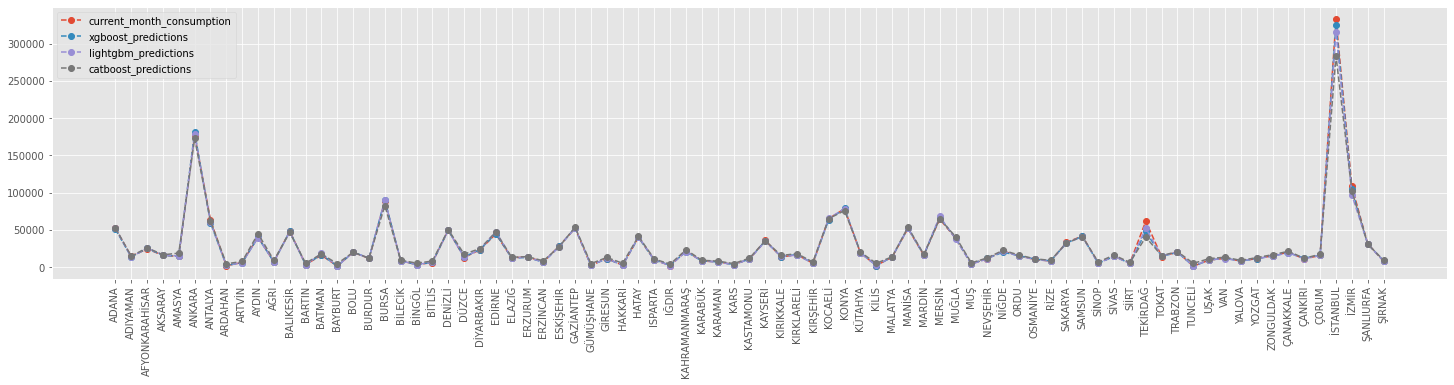

In [25]:
from src.utils.plotting import plot_metrics
plot_metrics(temp_df.reset_index(level="province"), col_x="province", col_y1="current_month_consumption", col_y2="xgboost_predictions", col_y3="lightgbm_predictions", col_y4="catboost_predictions")